In [28]:
import torch
import torch.nn as nn
import torchvision.models as models
from peft import LoraConfig, get_peft_model


In [29]:
unet = models.segmentation.deeplabv3_resnet50(pretrained=True)

/home/dcor/niskhizov/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dcor/niskhizov/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
unet.classifier[4] = nn.Conv2d(256, 3, kernel_size=1)

In [31]:
unet.backbone.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [32]:
# unet.backbone.layer4

In [33]:
# config = LoraConfig(
#     r=8,  # Low-rank parameter
#     lora_alpha=16,
#     lora_dropout=0.05,
#     target_modules=["conv1"]  # Apply LoRA to deeper layers
# )

# unet = get_peft_model(unet, config)

In [34]:

class LoRA_U_Net(nn.Module):
    def __init__(self):
        super(LoRA_U_Net, self).__init__()
        self.unet = models.segmentation.deeplabv3_resnet50(pretrained=True)
        
        # Modify classifier for image prediction task (3 output channels for RGB)
        self.unet.classifier[4] = nn.Conv2d(256, 3, kernel_size=1)

        # # Apply LoRA to the convolution layers
        # config = LoraConfig(
        #     r=8,  # Low-rank parameter
        #     lora_alpha=16,
        #     lora_dropout=0.05,
        #     target_modules=["conv1"]  # Apply LoRA to deeper layers
        # )

        # self.unet = get_peft_model(self.unet, config)

    def forward(self, x):
        return self.unet(x)['out'] + x  # Residual Learning

# Load model
model = LoRA_U_Net().cuda()

In [35]:
import glob
import tqdm
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [36]:
projections_dir = '/home/dcor/niskhizov/projections_pairs/projections_patch4/'
patterns_dir = "/home/dcor/niskhizov/projections_pairs/rnd_patterns_patch4/"
projections = glob.glob(projections_dir + '/*')
patterns = glob.glob(patterns_dir + '/*')
# load data from calibration
import pickle
with open('/home/dcor/niskhizov/AdversarialRendering//calibration_dump/calibration.pickle','rb') as f:
    H = pickle.load(f)
with open('/home/dcor/niskhizov/AdversarialRendering//calibration_dump/orig_ref_frame.pickle','rb') as f:
    orig_ref_frame = pickle.load(f)

In [37]:
from torchvision import transforms

tt = transforms.ToTensor()

import torch 
import kornia
H_t = torch.tensor(H).float().unsqueeze(0)
def warp(img):
    return kornia.geometry.transform.warp_perspective(img, H_t, (orig_ref_frame.shape[0], orig_ref_frame.shape[1]))

In [38]:
orig_ref_frame_tensor = tt(orig_ref_frame).unsqueeze(0)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

tp = transforms.ToPILImage()
tt = transforms.ToTensor()

# 300 600 resize

resizer = transforms.Resize((300, 600))


class ImagePairDataset(Dataset):
    def __init__(self, projections, patterns, transform=None):
        self.projections = projections
        self.patterns = patterns

    def __len__(self):
        return len(self.projections)

    def __getitem__(self, idx):
       
        proj_path = self.projections[idx]

        proj_image = cv2.imread(proj_path)

        proj_image = cv2.cvtColor(proj_image, cv2.COLOR_BGR2RGB)

        proj_pattern = proj_image#[185:235,284:384,:]#[150:250,180:380,:]

        pattern_path = self.patterns[idx]

        pattern = cv2.imread(pattern_path)#.transpose(1, 0, 2)

        proj_pattern = tt(proj_pattern)
        pattern = tt(pattern).unsqueeze(0)


        imag_w = warp(pattern)
        mask_w = warp(pattern*0+1)

        sum_tensor =  ((mask_w != 0) * -0.5 + 1) * orig_ref_frame_tensor + imag_w * 0.5

        sum_tensor = sum_tensor[0]
        

        return sum_tensor, proj_pattern 


dataset = ImagePairDataset(projections, patterns)

In [ ]:
train_size = int(0.8 * len(projections))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=8 )

In [ ]:
import tqdm

In [ ]:
# model = unet.cuda()

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for epoch in range(10):
    for idx,(anchor, target) in tqdm.tqdm(enumerate(train_dataloader)):  # Load (anchor image, modified target)
        anchor, target = anchor.cuda(), target.cuda()
        
        optimizer.zero_grad()
        pred = model(anchor)
        
        loss = nn.L1Loss()(pred, target)  # Use L1 loss since most pixels remain unchanged
        loss.backward()
        optimizer.step()

        if idx % 100 == 0:
    
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
            plt.imshow(pred[0].detach().cpu().numpy().transpose(1, 2, 0))
            plt.show()
            plt.imshow(target[0].detach().cpu().numpy().transpose(1, 2, 0))
            plt.show()
            plt.imshow(anchor[0].detach().cpu().numpy().transpose(1, 2, 0))
            plt.show()
            


In [ ]:
# save the model
torch.save(model.state_dict(), 'lora_unet.pth')

In [19]:
pred = model(anchor)

In [23]:
anchor.shape

torch.Size([3, 3, 480, 640])

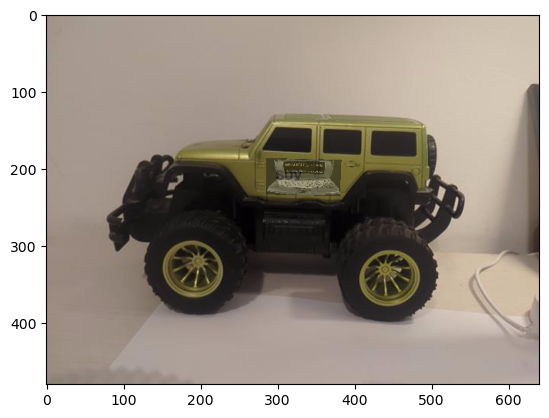

In [25]:
plt.imshow(anchor[0].detach().cpu().numpy().transpose(1, 2, 0))